In [3]:
# =============================================
# 1. CONFIGURACIÓN INICIAL
# =============================================

import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ruta al DW
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"

# Conexión
conn = sqlite3.connect(db_path)

# Cargar la vista combinada
df = pd.read_sql_query("SELECT * FROM vw_tipo_semana_modelo_extendida_v2", conn)
# Cerrar conexión
conn.close()

print(f"Registros cargados: {len(df)}")
df.head()


Registros cargados: 682


,id_jugador,microciclo_actual,carga_total,CE_total,CS_total,CR_total,entrenos_total_next,descansos_total_next,partidos_total_next,descansos_pre_partido_next,entrenos_pre_partido_next,entrenos_post_partido_next,tipo_semana_next
0,1,1,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,baja
1,1,2,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,baja
2,1,3,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,baja
3,1,4,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,baja
4,1,5,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,baja


In [4]:
# =========================================
# 1️⃣ Exploración inicial del dataset
# =========================================
import pandas as pd

print(f"Registros cargados: {len(df)}\n")
print("Columnas del dataframe:\n", list(df.columns))

# Tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

# Valores faltantes
print("\nValores faltantes por columna:")
print(df.isna().sum())

# Distribución de la etiqueta
print("\nDistribución de tipo_semana_next:")
print(df['tipo_semana_next'].value_counts(normalize=True) * 100)


Registros cargados: 682

Columnas del dataframe:
 ['id_jugador', 'microciclo_actual', 'carga_total', 'CE_total', 'CS_total', 'CR_total', 'entrenos_total_next', 'descansos_total_next', 'partidos_total_next', 'descansos_pre_partido_next', 'entrenos_pre_partido_next', 'entrenos_post_partido_next', 'tipo_semana_next']

Tipos de datos:
id_jugador                      int64
microciclo_actual               int64
carga_total                   float64
CE_total                      float64
CS_total                      float64
CR_total                      float64
entrenos_total_next           float64
descansos_total_next          float64
partidos_total_next           float64
descansos_pre_partido_next    float64
entrenos_pre_partido_next     float64
entrenos_post_partido_next    float64
tipo_semana_next               object
dtype: object

Valores faltantes por columna:
id_jugador                     0
microciclo_actual              0
carga_total                    0
CE_total                    

In [6]:
# =============================================
# 2.1 FILTRO DE JUGADORES Y MICRO-CICLOS
# =============================================

print(f"Registros cargados pre filtrado: {len(df)}\n")

# Jugadores que deben excluirse
jugadores_excluir = [1, 2, 3, 12, 30]

# Filtrar jugadores no válidos
df = df[~df["id_jugador"].isin(jugadores_excluir)]


microciclos_excluir = [1, 2, 3, 4, 5, 6, 7]

# Filtrar jugadores no válidos
df = df[~df["microciclo_actual"].isin(microciclos_excluir)]

print(f"Registros cargados post filtrado: {len(df)}\n")
# Distribución de la etiqueta
print("\nDistribución de tipo_semana_next:")
print(df['tipo_semana_next'].value_counts(normalize=True) * 100)


Registros cargados pre filtrado: 390

Registros cargados post filtrado: 390


Distribución de tipo_semana_next:
tipo_semana_next
media    48.974359
alta     29.230769
baja     21.794872
Name: proportion, dtype: float64


In [7]:
# =========================================
# 2️⃣ Preparación del dataset para el modelo
# =========================================
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Variables de entrada (estado actual + planificación próxima semana)
features = [
    'carga_total', 'CE_total', 'CS_total', 'CR_total',
    'entrenos_total_next', 'descansos_total_next', 'partidos_total_next',
    'descansos_pre_partido_next', 'entrenos_pre_partido_next', 'entrenos_post_partido_next'
]

X = df[features].copy()
y = df['tipo_semana_next'].copy()

# Codificar etiquetas (baja=0, media=1, alta=2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Escalar features numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print("✅ Dataset listo para el modelo")
print(f"X_train shape: {X_train.shape}")
print(f"y_train distribución: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"y_test distribución: {pd.Series(y_test).value_counts(normalize=True)}")


✅ Dataset listo para el modelo
X_train shape: (312, 10)
y_train distribución: 2    0.490385
0    0.291667
1    0.217949
Name: proportion, dtype: float64
y_test distribución: 2    0.487179
0    0.294872
1    0.217949
Name: proportion, dtype: float64



🔹 Resultados Random Forest
----------------------------------------
Accuracy: 0.731
F1-macro: 0.715

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.88      0.65      0.75        23
        baja       0.61      0.65      0.63        17
       media       0.72      0.82      0.77        38

    accuracy                           0.73        78
   macro avg       0.74      0.71      0.71        78
weighted avg       0.74      0.73      0.73        78



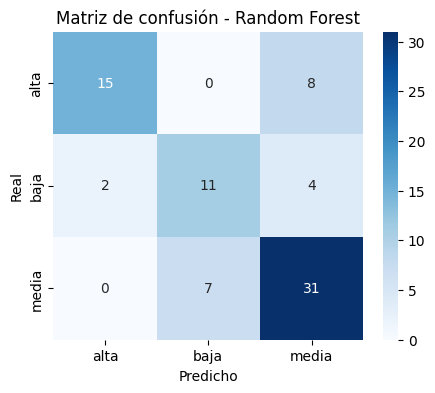


🔹 Resultados XGBoost
----------------------------------------
Accuracy: 0.731
F1-macro: 0.715

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.88      0.65      0.75        23
        baja       0.61      0.65      0.63        17
       media       0.72      0.82      0.77        38

    accuracy                           0.73        78
   macro avg       0.74      0.71      0.71        78
weighted avg       0.74      0.73      0.73        78



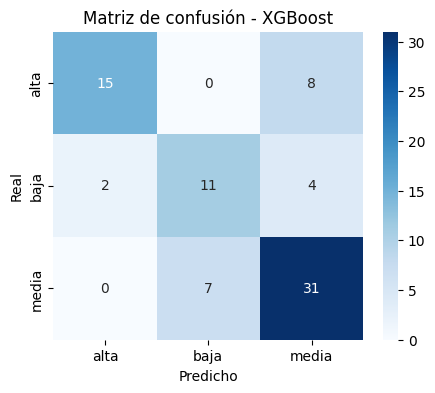

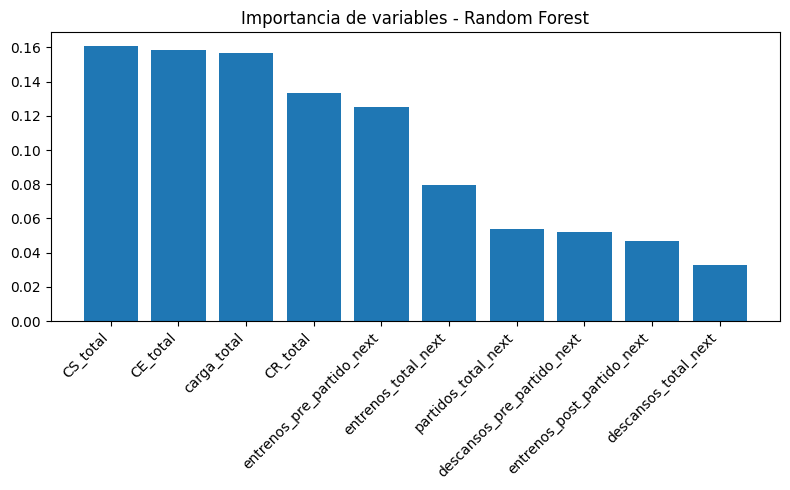

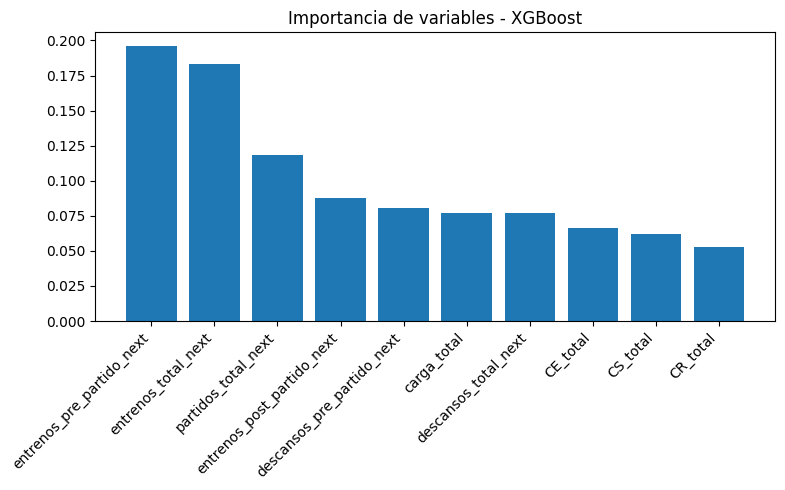

In [8]:
# =========================================
# 3️⃣ Entrenamiento y comparación de modelos
# =========================================

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Entrenamiento de Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight='balanced_subsample'
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Entrenamiento de XGBoost
xgb_model = XGBClassifier(
    n_estimators=350,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# =========================================
# 4️⃣ Evaluación de ambos modelos
# =========================================
def evaluar_modelo(nombre, y_true, y_pred):
    print(f"\n🔹 Resultados {nombre}")
    print("-" * 40)
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print("F1-macro:", round(f1_score(y_true, y_pred, average='macro'), 3))
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

# Evaluar ambos
evaluar_modelo("Random Forest", y_test, rf_pred)
evaluar_modelo("XGBoost", y_test, xgb_pred)

# =========================================
# 5️⃣ Comparación de importancia de variables
# =========================================
def mostrar_importancias(modelo, nombre):
    try:
        importancias = modelo.feature_importances_
        indices = np.argsort(importancias)[::-1]
        plt.figure(figsize=(8,5))
        plt.title(f"Importancia de variables - {nombre}")
        plt.bar(range(len(importancias)), importancias[indices], align='center')
        plt.xticks(range(len(importancias)), np.array(features)[indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"No se pudieron mostrar importancias para {nombre}: {e}")

mostrar_importancias(rf_model, "Random Forest")
mostrar_importancias(xgb_model, "XGBoost")


In [ ]:
# =============================================
# 🔹 Guardar modelo de tipo de semana (RF / XGB)
# =============================================
import joblib
import os

# Carpeta de salida (usa la misma estructura del proyecto)
output_dir = r"C:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\src\chivas_ml\ml\registry\modelo_clas_carga_semanal"
os.makedirs(output_dir, exist_ok=True)

# Guardar modelo Random Forest
joblib.dump(rf_model, os.path.join(output_dir, 'model_weektype_rf.pkl'))

# Guardar modelo XGBoost (opcional)
joblib.dump(xgb_model, os.path.join(output_dir, 'model_weektype_xgb.pkl'))

# Guardar escalador
joblib.dump(scaler, os.path.join(output_dir, 'scaler_weektype.pkl'))

print("✅ Modelo(s) y escalador guardados correctamente.")



✅ Modelo(s) y escalador guardados correctamente.
